In [64]:
%pip install scikit-image --upgrade

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import opendatasets as od
import kaggle
import zipfile
import time
import json
import os

import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from PIL import Image, ImageFile
from tqdm import tqdm
from torchvision import transforms, models
from tempfile import TemporaryDirectory 
from torch.utils.data import Dataset, DataLoader

cudnn.benchmark = True
plt.ion()  # interactive mode
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Download Data

In [66]:
if not os.path.isdir('dataset'):
    dataset_url = 'https://www.kaggle.com/datasets/qitvision/iwildcam2020-256'
    od.download(dataset_url, 'dataset')

In [67]:
image_dir = os.path.join('.', 'dataset', 'iwildcam2020-256', '256_images')

In [68]:
print(image_dir)

.\dataset\iwildcam2020-256\256_images


In [69]:
train_images_path = os.path.join(image_dir, 'train', 'images')
test_images_path = os.path.join(image_dir, 'test', 'images')

In [70]:
print(train_images_path)

.\dataset\iwildcam2020-256\256_images\train\images


In [71]:
if not os.path.isdir('annotations'):
    competition_name = 'iwildcam-2020-fgvc7'
    file_name = 'iwildcam2020_train_annotations.json'
    folder_name = './annotations'
    file_path = './annotations/' + '/' + file_name + '.zip'
    kaggle.api.authenticate()
    kaggle.api.competition_download_file(competition=competition_name, file_name=file_name, path=folder_name)
    with zipfile.ZipFile(file_path, 'r') as zip_re:
        zip_re.extractall(path=folder_name)

    os.rename(os.path.join(folder_name, file_name), os.path.join(folder_name, 'train_data.json'))
    os.remove(file_path)

## Load Data

In [72]:
train_annotations_dir = './annotations'
with open(train_annotations_dir + '/train_data.json', 'r') as f:
    train_data = json.load(f)

print(train_data.keys())

dict_keys(['annotations', 'images', 'categories', 'info'])


In [73]:
pd.DataFrame(train_data['annotations']).head()

count                              image_id  \
0      1  96b00332-21bc-11ea-a13a-137349068a90   
1      1  879d74d8-21bc-11ea-a13a-137349068a90   
2      1  9017f7aa-21bc-11ea-a13a-137349068a90   
3      1  90d93c58-21bc-11ea-a13a-137349068a90   
4      1  887cd0ec-21bc-11ea-a13a-137349068a90   

                                     id  category_id  
0  a292dd3c-21bc-11ea-a13a-137349068a90           73  
1  a0afcfc0-21bc-11ea-a13a-137349068a90            4  
2  a306e9c0-21bc-11ea-a13a-137349068a90          227  
3  9eed94c4-21bc-11ea-a13a-137349068a90          250  
4  a2a4dd7a-21bc-11ea-a13a-137349068a90            2

In [74]:
pd.DataFrame(train_data['images']).head()

seq_num_frames  location                 datetime  \
0               1       267  2013-08-08 11:45:00.000   
1               1       264  2013-08-01 22:31:00.000   
2               1        45  2013-04-17 11:15:00.000   
3               1        45  2013-04-23 08:26:00.000   
4               1        45  2013-04-24 13:51:00.000   

                                     id  frame_num  \
0  96b00332-21bc-11ea-a13a-137349068a90          1   
1  879d74d8-21bc-11ea-a13a-137349068a90          1   
2  9017f7aa-21bc-11ea-a13a-137349068a90          1   
3  90d93c58-21bc-11ea-a13a-137349068a90          1   
4  887cd0ec-21bc-11ea-a13a-137349068a90          1   

                                 seq_id  width  height  \
0  96b004ea-21bc-11ea-a13a-137349068a90   1795    1222   
1  879d7654-21bc-11ea-a13a-137349068a90   2739    1772   
2  9017f8cc-21bc-11ea-a13a-137349068a90   1891    1222   
3  90d93e38-21bc-11ea-a13a-137349068a90   1795    1222   
4  887cd29a-21bc-11ea-a13a-137349068a90   1812    1196   

                                  file_name  
0  96b00332-21bc-11ea-a13a-137349068a90.jpg  
1  879d74d8-21bc-11ea-a13a-137349068a90.jpg  
2  9017f7aa-21bc-11ea-a13a-137349068a90.jpg  
3  90d93c58-21bc-11ea-a13a-137349068a90.jpg  
4  887cd0ec-21bc-11ea-a13a-137349068a90.jpg

In [75]:
pd.DataFrame(train_data['categories']).head()

count  id                 name
0  78981   0                empty
1   6355   2       tayassu pecari
2   5833   3  dasyprocta punctata
3    619   4       cuniculus paca
4   4453   6        puma concolor

In [76]:
# Join the dataframes

df = pd.DataFrame({'id': [item['id'] for item in train_data['annotations']],
                         'category_id': [item['category_id'] for item in train_data['annotations']],
                         'image_id': [item['image_id'] for item in train_data['annotations']],
                         'file_name': [item['file_name'] for item in train_data['images']]})

df.head()

id  category_id  \
0  a292dd3c-21bc-11ea-a13a-137349068a90           73   
1  a0afcfc0-21bc-11ea-a13a-137349068a90            4   
2  a306e9c0-21bc-11ea-a13a-137349068a90          227   
3  9eed94c4-21bc-11ea-a13a-137349068a90          250   
4  a2a4dd7a-21bc-11ea-a13a-137349068a90            2   

                               image_id  \
0  96b00332-21bc-11ea-a13a-137349068a90   
1  879d74d8-21bc-11ea-a13a-137349068a90   
2  9017f7aa-21bc-11ea-a13a-137349068a90   
3  90d93c58-21bc-11ea-a13a-137349068a90   
4  887cd0ec-21bc-11ea-a13a-137349068a90   

                                  file_name  
0  96b00332-21bc-11ea-a13a-137349068a90.jpg  
1  879d74d8-21bc-11ea-a13a-137349068a90.jpg  
2  9017f7aa-21bc-11ea-a13a-137349068a90.jpg  
3  90d93c58-21bc-11ea-a13a-137349068a90.jpg  
4  887cd0ec-21bc-11ea-a13a-137349068a90.jpg

In [77]:
print(df.shape)

(217959, 4)


In [78]:
# Removes ro with no corresponding images in the dataset
def remove_rows():
    for i in tqdm(df['file_name']):
        try:
            Image.open(train_images_path + '/' + i)
        except:
            print(i)
            df.drop(df.loc[df['file_name'] == i].index, inplace=True)

In [79]:
%%time
remove_rows()

 57%|█████▋    | 123547/217959 [01:44<01:03, 1495.18it/s]

99136aa6-21bc-11ea-a13a-137349068a90.jpg
87022118-21bc-11ea-a13a-137349068a90.jpg
8f17b296-21bc-11ea-a13a-137349068a90.jpg
883572ba-21bc-11ea-a13a-137349068a90.jpg


 57%|█████▋    | 123697/217959 [01:46<05:43, 274.47it/s] 

896c1198-21bc-11ea-a13a-137349068a90.jpg
8792549a-21bc-11ea-a13a-137349068a90.jpg


100%|██████████| 217959/217959 [02:54<00:00, 1249.34it/s]


CPU times: total: 31.7 s
Wall time: 2min 54s


In [80]:
print(df.shape)

(217953, 4)


## Data Augmentations

In [97]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [98]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_dataframe, root_dir, transform=None):
        self.root_dir = root_dir
        self.df = annotations_dataframe
        self.transform = transform
        self.df['image_path'] = self.df['file_name'].apply(lambda x: os.path.join(root_dir, x))
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        image = Image.open(img_path)
        
        label = self.df.iloc[idx]['category_id']
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [99]:
train_df, validation_df = train_test_split(df, test_size=0.25, shuffle=True)

In [100]:
datasets = {
    'train': CustomImageDataset(annotations_dataframe=train_df, root_dir=train_images_path, transform=data_transforms['train']),
    'val': CustomImageDataset(annotations_dataframe=validation_df, root_dir=train_images_path, transform=data_transforms['val'])
}

In [101]:
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

In [102]:
dataloaders = {
    x: DataLoader(datasets[x], batch_size=32, shuffle=True)
               for x in ['train', 'val']
}

In [103]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


## Data Visualization

In [108]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    plt.figure(figsize=(25,25))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [109]:
# Get a batch of training data
data_iter = iter(dataloaders['train'])
inputs, classes = next(data_iter)

In [110]:
CATEGORIES = pd.DataFrame(train_data['categories'])

CATEGORIES.head()

count  id                 name
0  78981   0                empty
1   6355   2       tayassu pecari
2   5833   3  dasyprocta punctata
3    619   4       cuniculus paca
4   4453   6        puma concolor

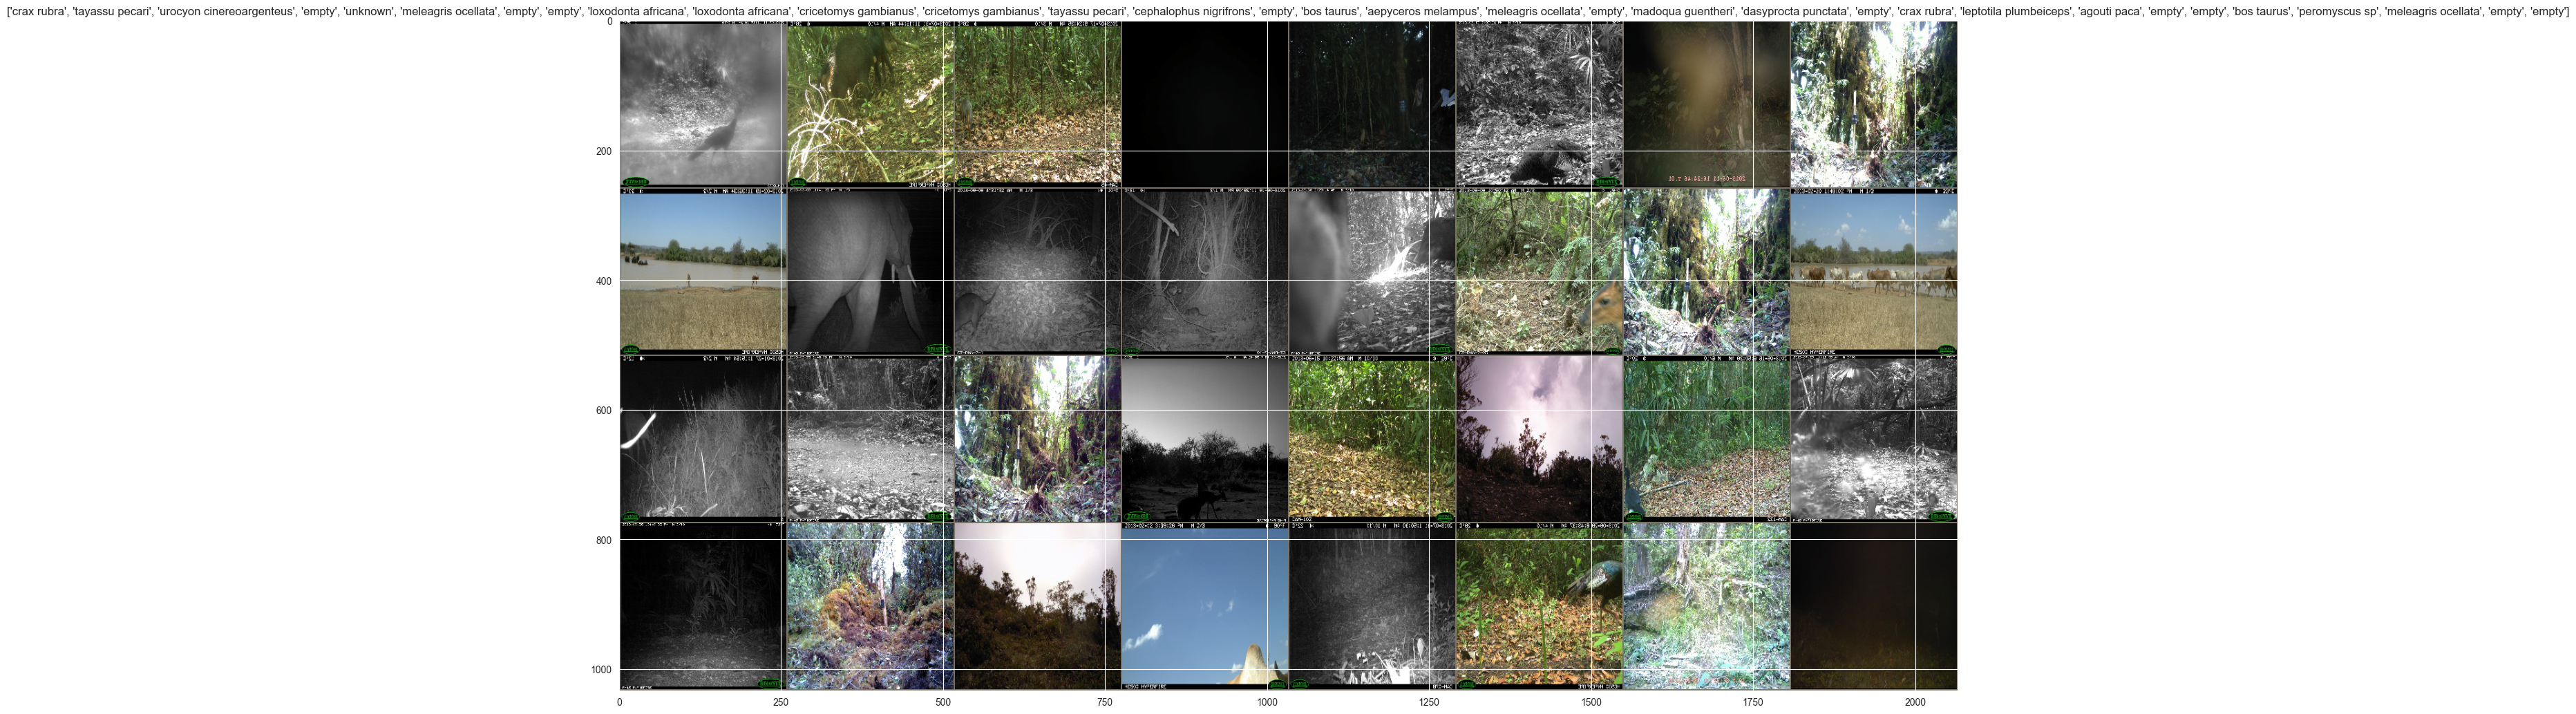

In [111]:
out = torchvision.utils.make_grid(inputs)

category_ids = classes.cpu().numpy()
category_names = []
for idx in category_ids:
    # Find the corresponding category name from the DataFrame
    category_name = CATEGORIES.loc[CATEGORIES['id'] == idx, 'name'].values[0]
    category_names.append(category_name)
    
imshow(out, title=category_names)

In [112]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        
                        float_labels = labels.type(torch.FloatTensor)
                        float_labels.requires_grad = True
                        float_preds = preds.type(torch.FloatTensor)
                        float_preds.requires_grad = True
                        loss = criterion(float_preds, float_labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [113]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                pred_class = CATEGORIES.loc[CATEGORIES['id'] == preds[j], 'name'].values[0]
                ax.set_title(f'predicted: {pred_class}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [114]:
CLASS_UNQ = df['category_id'].unique()

NUM_CLASSES = len(CLASS_UNQ)

In [115]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_features = model.fc.in_features

model.fc = nn.Linear(num_features, NUM_CLASSES)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 320810.4992 Acc: 0.0004
val Loss: 330362.7595 Acc: 0.0004

Epoch 1/24
----------
train Loss: 320478.5549 Acc: 0.0003
val Loss: 321513.4569 Acc: 0.0004

Epoch 2/24
----------
train Loss: 320530.6680 Acc: 0.0003
val Loss: 322687.8332 Acc: 0.0004

Epoch 3/24
----------
